In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import bambi as bmb
import xarray as xr
import random
%load_ext rpy2.ipython


In [2]:
df = pd.read_csv('../results/model/Nested_model/Reduced_Ne_Pi_recomb.csv')

Filter based on callability and remove X chromosome and adjust for missing coverage by extrapolating

In [3]:
df = df[df['freq_mean']>0.7]
df = df[df['chr']!='chrX']
df['corrected_pi'] = df['PI']*df['freq_mean']

Standardize and center so priors can be mu = 0 and sigma = 1
This is done by taking the species specific mean 

In [4]:
grouped_df = df.groupby('full_species')
means = pd.DataFrame()
# Step 2: Calculate Mean and Standard Deviation
means[['mean_pi_species','mean_cm_per_mb_species']] = grouped_df[['corrected_pi', 'cm_per_mb']].mean()
means[['sd_pi_species','sd_cm_per_mb_species']] = grouped_df[['corrected_pi', 'cm_per_mb']].std()
means['primate_mean_ne'] = df['NE_MEDIAN'].mean()
means['primate_sd_ne'] = df['NE_MEDIAN'].std()


means = means[['mean_pi_species','mean_cm_per_mb_species', 'sd_pi_species','sd_cm_per_mb_species', 'primate_mean_ne', 'primate_sd_ne']]

In [8]:
# Merge dataframes on the 'full_species' column
merged_df = pd.merge(df, means, on='full_species')

# Reset the index to remove the default index column
merged_df = merged_df.reset_index(drop=True)


In [9]:
merged_df['z_pi'] = (merged_df['corrected_pi']-merged_df['mean_pi_species'])/merged_df['sd_pi_species']
merged_df['z_cm_per_mb'] = (merged_df['cm_per_mb']-merged_df['mean_cm_per_mb_species'])/merged_df['sd_cm_per_mb_species']
merged_df['z_ne'] = (merged_df['NE_MEDIAN']-merged_df['primate_mean_ne'])/merged_df['primate_sd_ne']
z_df = merged_df[['full_species','NE_MEDIAN','z_pi', 'z_cm_per_mb', 'z_ne']]

Downsample for easier sampling 

In [12]:
z_df = z_df[z_df['full_species'].isin(['Allenopithecus_nigroviridis', 'Allochrocebus_lhoesti',
       'Allochrocebus_preussi', 'Allochrocebus_solatus',
       'Alouatta_belzebul', 'Alouatta_caraya', 'Alouatta_discolor',
       'Alouatta_juara', 'Alouatta_macconnelli', 'Alouatta_nigerrima',
       'Alouatta_palliata', 'Alouatta_puruensis', 'Alouatta_seniculus',
       'Aotus_azarae', 'Aotus_griseimembra', 'Aotus_trivirgatus',
       'Aotus_vociferans', 'Arctocebus_calabarensis', 'Ateles_belzebuth',
       'Ateles_chamek', 'Ateles_geoffroyi', 'Ateles_marginatus',
       'Ateles_paniscus', 'Cacajao_ayresi', 'Cacajao_calvus',
       'Cacajao_hosomi', 'Cacajao_melanocephalus', 'Callimico_goeldii',
       'Callithrix_geoffroyi', 'Callithrix_jacchus', 'Callithrix_kuhlii',
       'Cebuella_niveiventris', 'Cebuella_pygmaea', 'Cebus_albifrons',
       'Cebus_olivaceus', 'Cebus_unicolor', 'Cercocebus_chrysogaster',
       'Cercocebus_lunulatus', 'Cercocebus_torquatus',
       'Cercopithecus_ascanius', 'Cercopithecus_cephus',
       'Cercopithecus_diana', 'Cercopithecus_hamlyni',
       'Cercopithecus_lowei', 'Cercopithecus_mitis', 'Cercopithecus_mona',
       'Cercopithecus_neglectus', 'Cercopithecus_nictitans',
       'Cercopithecus_petaurista', 'Cercopithecus_pogonias','Pan_paniscus', 'Pan_troglodytes',
       'Perodicticus_ibeanus', 'Perodicticus_potto', 'Pithecia_albicans',
       'Pithecia_chrysocephala', 'Pithecia_hirsuta',
       'Pithecia_mittermeieri', 'Pithecia_pissinattii',
       'Pithecia_vanzolinii', 'Plecturocebus_bernhardi',
       'Plecturocebus_brunneus', 'Plecturocebus_caligatus',
       'Plecturocebus_cinerascens', 'Plecturocebus_cupreus',
       'Plecturocebus_dubius', 'Gorilla_beringei', 'Gorilla_gorilla'])]

In [13]:
z_df

,full_species,NE_MEDIAN,z_pi,z_cm_per_mb,z_ne
0,Allenopithecus_nigroviridis,48795.239046,0.035514,-0.820631,-0.330025
1,Allenopithecus_nigroviridis,48795.239046,0.036663,0.266051,-0.330025
2,Allenopithecus_nigroviridis,48795.239046,0.849468,-0.166861,-0.330025
3,Allenopithecus_nigroviridis,48795.239046,-0.093303,-0.572792,-0.330025
4,Allenopithecus_nigroviridis,48795.239046,-0.149338,0.097297,-0.330025
...,...,...,...,...,...
2295877,Plecturocebus_dubius,77056.752279,-1.492908,-0.886819,0.107628
2295878,Plecturocebus_dubius,77056.752279,-0.614678,1.320263,0.107628
2295879,Plecturocebus_dubius,77056.752279,-1.170127,-0.648252,0.107628
2295880,Plecturocebus_dubius,77056.752279,-0.797875,0.388002,0.107628


In [14]:
unique_Species = z_df['full_species'].unique()
species_lookup = dict(zip(unique_Species, range(len(unique_Species))))
Ne =  (pd.DataFrame([z_df['full_species'], z_df['z_ne']]).transpose()).drop_duplicates()
pi = z_df['z_pi'].values
recombinationrate = z_df['z_cm_per_mb'].values
species = z_df['full_species'].replace(species_lookup).values

Bambi formulation 

In [23]:
#formula = "corrected_pi ~ (cm_per_mb|full_species) + (NE_MEDIAN|full_species)"

In [24]:
# Create the Bambi model
#bambi_model = bmb.Model(formula, data=df)

In [25]:
#bambi_model.build()
#bambi_model.graph()

In [26]:
# Run the model
#bambi_results = bambi_model.fit()

In [28]:

# Print the summary
#print(bambi_results.summary())

PYMC formulation 

Make variables

In [15]:
hierarchical_model = pm.Model(coords = {"Species": unique_Species, 
                                        "obs_id": np.arange(len(recombinationrate))})

In [16]:
with hierarchical_model:
# Data
    recomb = pm.ConstantData('recomb', recombinationrate, dims = 'obs_id')
    pi = pm.ConstantData('pi', pi, dims = 'obs_id')
    sp = pm.ConstantData('sp',species, dims = 'obs_id')
    Ne =  pm.ConstantData('Ne', Ne['z_ne'], dims = 'Species')

# Hyperpriors:
    g0 = pm.Normal("g0", mu=0, sigma=1)
    g1 = pm.Normal("g1", mu=0, sigma=1)
    h0 = pm.Normal("h0", mu=0, sigma=1)
    h1 = pm.Normal("h1", mu=0, sigma=1)

    mu_a = g0+g1*Ne
    mu_b = h0+h1*Ne
    sigma_a = pm.Exponential("sigma_a", 1)
    sigma_b = pm.Exponential("sigma_b", 1)
# Varying intercepts:
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, dims="Species")
# Varying slopes:
    b = pm.Normal("b", mu=mu_b, sigma=sigma_b, dims="Species")
# Expected value per species:
    y = a[sp] + b[sp] * recomb
# Model error
    sigma = pm.Exponential("sigma", 0.01)
    Pi = pm.Normal("Pi", mu=y, sigma=sigma, observed=pi, dims="obs_id")

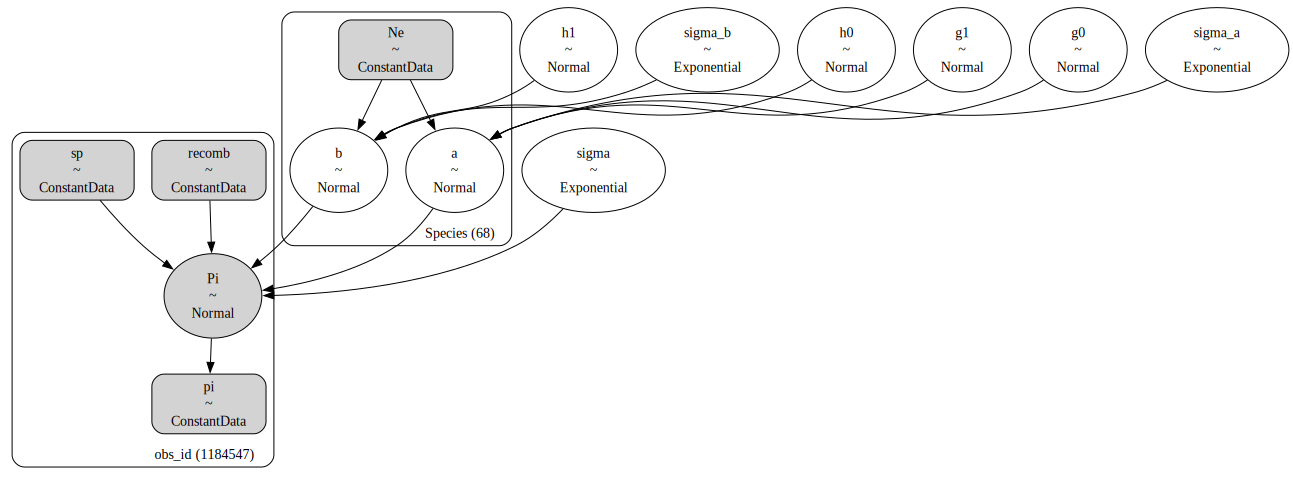

In [17]:
pm.model_to_graphviz(hierarchical_model)

In [18]:
with hierarchical_model:
    hier_reg_idata = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g0, g1, h0, h1, sigma_a, sigma_b, a, b, sigma]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 16182 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 320 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
#with hierarchical_model:
#   hier_reg_idata = pm.sample(2000, tune=2000, target_accept=0.99, return_inferencedata=True,
#                                 progressbar=True, cores=1, chains=4)

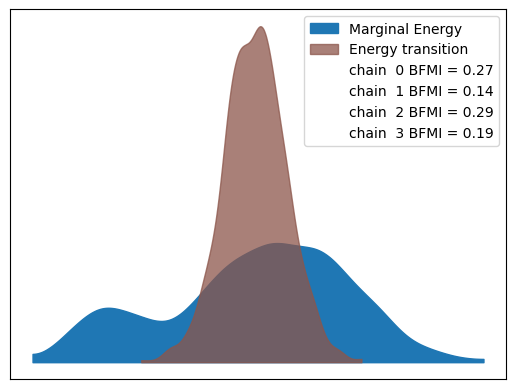

In [19]:
az.plot_energy(hier_reg_idata);

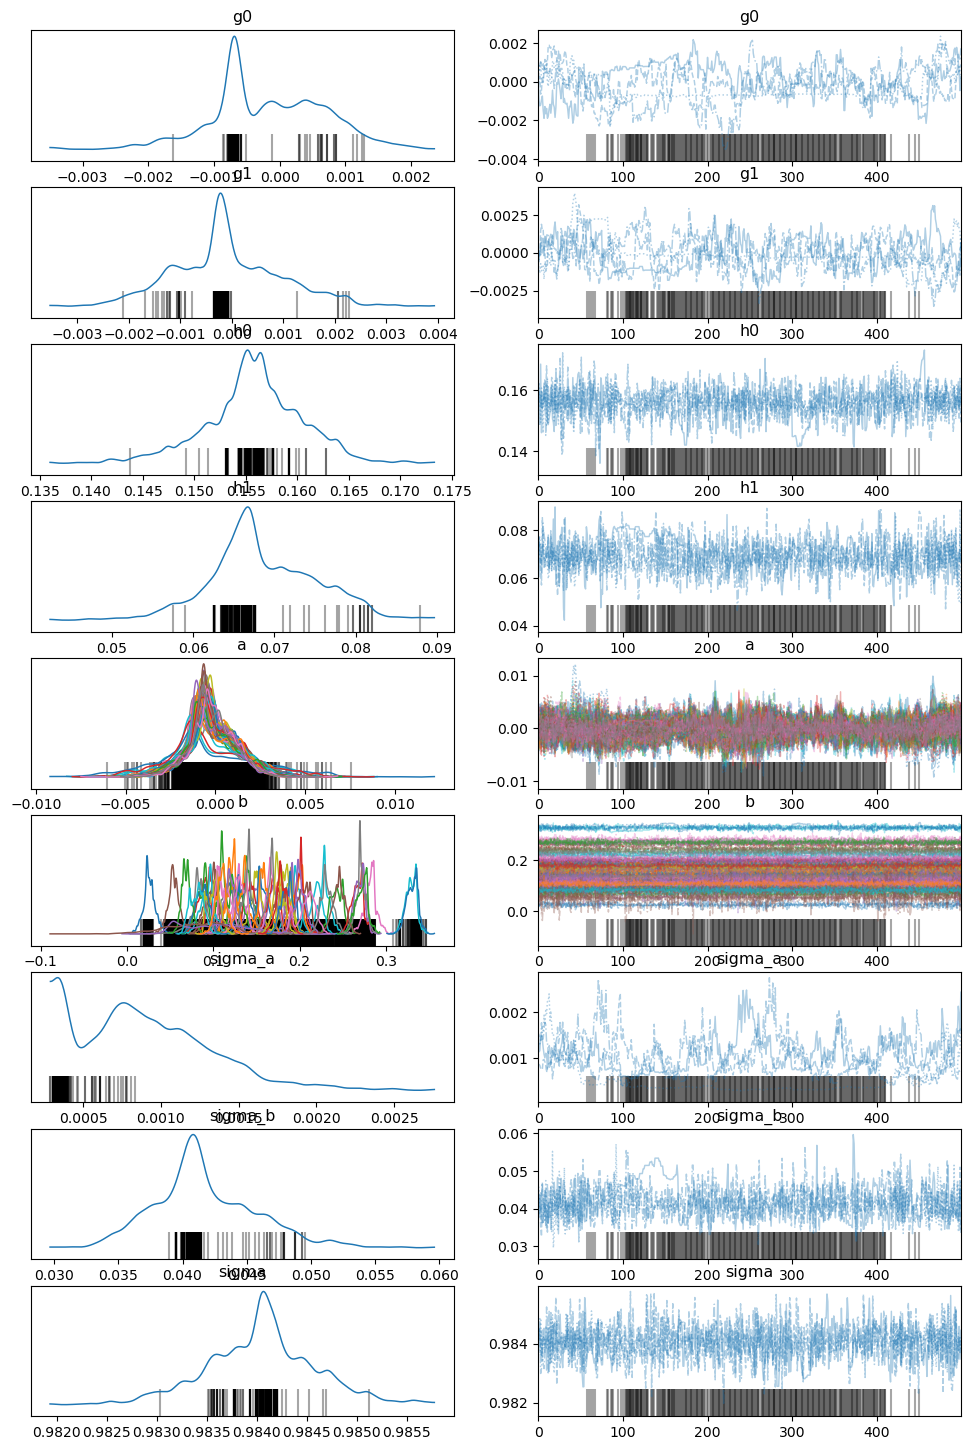

In [24]:
az.plot_trace(hier_reg_idata, combined=True);

In [23]:
g0 = hier_reg_idata.posterior.g0.to_dataframe()
g0.to_csv("../results/model/Nested_model/g0_14_12", sep="\t")
g1 = hier_reg_idata.posterior.g1.to_dataframe()
g1.to_csv("../results/model/Nested_model/g1_14_12_2023", sep="\t")
h0 = hier_reg_idata.posterior.h0.to_dataframe()
h0.to_csv("../results/model/Nested_model/h0_14_12_2023", sep="\t")
h1 = hier_reg_idata.posterior.h1.to_dataframe()
h1.to_csv("../results/model/Nested_model/h1_14_12_2023", sep="\t")
sigma_a = hier_reg_idata.posterior.sigma_a.to_dataframe()
sigma_a.to_csv("../results/model/Nested_model/sigma_a_13_12_2023", sep="\t")
sigma_b = hier_reg_idata.posterior.sigma_b.to_dataframe()
sigma_b.to_csv("../results/model/Nested_model/sigma_b_14_12_2023", sep="\t")
a = hier_reg_idata.posterior.a.to_dataframe()
a.to_csv("../results/model/Nested_model/a_14_12_2023", sep="\t")
b = hier_reg_idata.posterior.b.to_dataframe()
b.to_csv("../results/model/Nested_model/b_14_12_2023", sep="\t")
sgm = hier_reg_idata.posterior.sigma.to_dataframe()
sgm.to_csv("../results/model/Nested_model/sigma_model_14_12_2023", sep="\t")

Log scaled Ne model

In [5]:
#TAKING THE LOG TO BOTH NE AND CM_PER_MB
means_log = pd.DataFrame()
# Step 2: Calculate Mean and Standard Deviation
means_log['mean_pi_species'] = grouped_df['corrected_pi'].mean()
means_log['mean_cm_per_mb_species'] = np.log10(grouped_df['cm_per_mb'].mean())
means_log['sd_pi_species'] = grouped_df['corrected_pi'].std()
means_log['sd_cm_per_mb_species'] = np.log10(grouped_df['cm_per_mb'].std())
means_log['primate_mean_ne'] = np.log10(df['NE_MEDIAN'].mean())
means_log['primate_sd_ne'] = np.log10(df['NE_MEDIAN'].std())

means_log = means_log[['mean_pi_species','mean_cm_per_mb_species', 'sd_pi_species','sd_cm_per_mb_species', 'primate_mean_ne', 'primate_sd_ne']]

In [6]:
means_log

,mean_pi_species,mean_cm_per_mb_species,sd_pi_species,sd_cm_per_mb_species,primate_mean_ne,primate_sd_ne
full_species,,,,,,
Allenopithecus_nigroviridis,0.001442,0.119845,0.000671,0.194878,4.845759,4.810065
Allochrocebus_lhoesti,0.002513,0.121013,0.001146,0.196199,4.845759,4.810065
Allochrocebus_preussi,0.002603,0.121509,0.001614,0.196634,4.845759,4.810065
Allochrocebus_solatus,0.003025,0.125243,0.001887,0.198234,4.845759,4.810065
Alouatta_belzebul,0.001640,0.160389,0.000908,0.210100,4.845759,4.810065
...,...,...,...,...,...,...
Trachypithecus_melamera,0.001058,0.177959,0.000767,0.221281,4.845759,4.810065
Trachypithecus_phayrei,0.000651,0.122828,0.000886,0.199057,4.845759,4.810065
Trachypithecus_pileatus,0.001190,0.116634,0.000755,0.193985,4.845759,4.810065


In [7]:
# Merge dataframes on the 'full_species' column
merged_log_df = pd.merge(df, means, on='full_species')

# Reset the index to remove the default index column
merged_log_df = merged_log_df.reset_index(drop=True)


In [8]:
merged_log_df['z_pi'] = (merged_log_df['corrected_pi']-merged_log_df['mean_pi_species'])/merged_log_df['sd_pi_species']
merged_log_df['z_cm_per_mb'] = (merged_log_df['cm_per_mb']-merged_log_df['mean_cm_per_mb_species'])/merged_log_df['sd_cm_per_mb_species']
merged_log_df['z_ne'] = (merged_log_df['NE_MEDIAN']-merged_log_df['primate_mean_ne'])/merged_log_df['primate_sd_ne']
z_log_df = merged_log_df[['full_species','NE_MEDIAN','z_pi', 'z_cm_per_mb', 'z_ne']]

In [10]:
z_log_df = z_log_df[z_log_df['full_species'].isin(['Allenopithecus_nigroviridis', 'Allochrocebus_lhoesti',
       'Allochrocebus_preussi', 'Allochrocebus_solatus',
       'Alouatta_belzebul', 'Alouatta_caraya', 'Alouatta_discolor',
       'Alouatta_juara', 'Alouatta_macconnelli', 'Alouatta_nigerrima',
       'Alouatta_palliata', 'Alouatta_puruensis', 'Alouatta_seniculus',
       'Aotus_azarae', 'Aotus_griseimembra', 'Aotus_trivirgatus',
       'Aotus_vociferans', 'Arctocebus_calabarensis', 'Ateles_belzebuth',
       'Ateles_chamek', 'Ateles_geoffroyi', 'Ateles_marginatus',
       'Ateles_paniscus', 'Cacajao_ayresi', 'Cacajao_calvus',
       'Cacajao_hosomi', 'Cacajao_melanocephalus', 'Callimico_goeldii',
       'Callithrix_geoffroyi', 'Callithrix_jacchus', 'Callithrix_kuhlii',
       'Cebuella_niveiventris', 'Cebuella_pygmaea', 'Cebus_albifrons',
       'Cebus_olivaceus', 'Cebus_unicolor', 'Cercocebus_chrysogaster',
       'Cercocebus_lunulatus', 'Cercocebus_torquatus',
       'Cercopithecus_ascanius', 'Cercopithecus_cephus',
       'Cercopithecus_diana', 'Cercopithecus_hamlyni',
       'Cercopithecus_lowei', 'Cercopithecus_mitis', 'Cercopithecus_mona',
       'Cercopithecus_neglectus', 'Cercopithecus_nictitans',
       'Cercopithecus_petaurista', 'Cercopithecus_pogonias','Pan_paniscus', 'Pan_troglodytes',
       'Perodicticus_ibeanus', 'Perodicticus_potto', 'Pithecia_albicans',
       'Pithecia_chrysocephala', 'Pithecia_hirsuta',
       'Pithecia_mittermeieri', 'Pithecia_pissinattii',
       'Pithecia_vanzolinii', 'Plecturocebus_bernhardi',
       'Plecturocebus_brunneus', 'Plecturocebus_caligatus',
       'Plecturocebus_cinerascens', 'Plecturocebus_cupreus',
       'Plecturocebus_dubius', 'Gorilla_beringei', 'Gorilla_gorilla'])]

In [13]:
unique_Species_log = z_log_df['full_species'].unique()
species_lookup_log = dict(zip(unique_Species_log, range(len(unique_Species_log))))
Ne_log =  (pd.DataFrame([z_log_df['full_species'], z_log_df['z_ne']]).transpose()).drop_duplicates()
pi_log = z_log_df['z_pi'].values
recombinationrate_log = z_log_df['z_cm_per_mb'].values
species_log = z_log_df['full_species'].replace(species_lookup_log).values

In [14]:
hierarchical_log_scaled_ne_cmpermb_model = pm.Model(coords = {"Species": unique_Species_log, 
                                        "obs_id": np.arange(len(recombinationrate_log))})
non_centered = True

In [15]:
with hierarchical_log_scaled_ne_cmpermb_model:
# Data
    recomb = pm.ConstantData('recomb', recombinationrate_log, dims = 'obs_id')
    pi = pm.ConstantData('pi', pi_log, dims = 'obs_id')
    sp = pm.ConstantData('sp',species_log, dims = 'obs_id')
    Ne =  pm.ConstantData('Ne', Ne_log['z_ne'], dims = 'Species')

# Hyperpriors:
    g0 = pm.Normal("g0", mu=0, sigma=1)
    g1 = pm.Normal("g1", mu=0, sigma=1)
    h0 = pm.Normal("h0", mu=0, sigma=1)
    h1 = pm.Normal("h1", mu=0, sigma=1)

    mu_a = g0+g1*Ne
    mu_b = h0+h1*Ne
    sigma_a = pm.Exponential("sigma_a", 1)
    sigma_b = pm.Exponential("sigma_b", 1)

    if non_centered == True:
        # Varying intercepts:
        a_offset = pm.Normal("a_offset", 0, sigma=1, dims="Species")
        a = pm.Deterministic("a", mu_a + a_offset * sigma_a, dims="Species")
        # Varying slopes:
        b_offset = pm.Normal("b_offset", 0, sigma=1, dims="Species")
        b = pm.Deterministic("b", mu_b + b_offset * sigma_b, dims="Species")
    else:
        # Varying intercepts:
        a = pm.Normal("a", mu=mu_a, sigma=sigma_a, dims="Species")
        # Varying slopes:
        b = pm.Normal("b", mu=mu_b, sigma=sigma_b, dims="Species")
# Expected value per species:
    y = a[sp] + b[sp] * recomb
# Model error
    #sigma = pm.Normal("sigma", mu=1, sigma=1)
    Pi = pm.Normal("Pi", mu=y, sigma=1, observed=pi, dims="obs_id")

In [16]:
with hierarchical_log_scaled_ne_cmpermb_model:
    idata = pm.sample_prior_predictive(samples=50)

Sampling: [Pi, a_offset, b_offset, g0, g1, h0, h1, sigma_a, sigma_b]


<Axes: xlabel='Pi / Pi'>

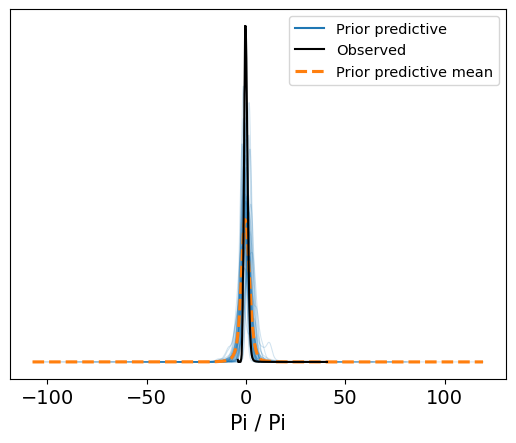

In [17]:
az.plot_ppc(idata, group='prior')

In [ ]:
with hierarchical_log_scaled_ne_cmpermb_model:
    hierarchical_log_scaled_ne_cmpermb_model_idata = pm.sample(1000, target_accept=0.99, return_inferencedata=True,
                                 progressbar=True, cores=4, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g0, g1, h0, h1, sigma_a, sigma_b, a_offset, b_offset]


trace_file = "{}/{}_{}_{}_model.nc".format(path_mod, anc, sta, modeltype)
if os.path.exists(trace_file):
    print("Trace exists, loading...")
    trace_model_with_apha = az.from_netcdf(trace_file)
else:
    with model_with_apha:
        print("Trace does not exist, sampling...")
        trace_model_with_apha = pm.sample(return_inferencedata=True)
        trace_model_with_apha.to_netcdf(trace_file)

In [ ]:
az.plot_energy(hierarchical_log_scaled_ne_cmpermb_model);

In [ ]:
az.plot_trace(hierarchical_log_scaled_ne_cmpermb_model, combined=True);

In [ ]:
g0 = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.g0.to_dataframe()
g0.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/g0_15_12", sep="\t")
g1 = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.g1.to_dataframe()
g1.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/g1_15_12_2023", sep="\t")
h0 = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.h0.to_dataframe()
h0.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/h0_15_12_2023", sep="\t")
h1 = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.h1.to_dataframe()
h1.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/h1_15_12_2023", sep="\t")
sigma_a = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.sigma_a.to_dataframe()
sigma_a.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/sigma_a_15_12_2023", sep="\t")
sigma_b = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.sigma_b.to_dataframe()
sigma_b.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/sigma_b_15_12_2023", sep="\t")
a = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.a.to_dataframe()
a.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/a_15_12_2023", sep="\t")
b = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.b.to_dataframe()
b.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/b_15_12_2023", sep="\t")
sgm = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.sigma.to_dataframe()
sgm.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/sigma_model_15_12_2023", sep="\t")
if non_centered is True:
    b_offset = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.b_offset.to_dataframe()
    b_offset.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/b_offset_15_12_2023", sep="\t")
    a_offset = hierarchical_log_scaled_ne_cmpermb_model_idata.posterior.a_offset.to_dataframe()
    a_offset.to_csv("../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/a_offset_15_12_2023", sep="\t")
hierarchical_log_scaled_ne_cmpermb_model_idata.to_netdf('../results/model/Nested_model/hierarchical_log_scaled_ne_cmpermb_model/hierarchical_log_scaled_ne_cmpermb_model.nc')